<a href="https://colab.research.google.com/github/yuvalofek/Statistical-Rethinking/blob/main/Statistical_Rethinking_Ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import numpy.random as npr
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

Credit to:
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_02.ipynb

# From the Chapter

In [ ]:
ways = np.array([0, 3, 8, 9, 0])
ways/ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

In [ ]:
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

In [ ]:
n_trials = 1
p = 0.67
size = (15,)

samples = npr.binomial(n_trials, p=p, size=size)
print(f"Samples: {samples}")

Samples: [1 1 1 0 0 1 1 0 1 1 1 1 1 1 1]


## 2.5


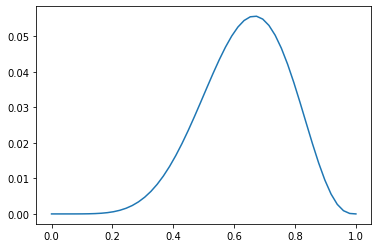

In [ ]:
N_grid = 50
grid = np.linspace(0,1, N_grid)
prior = np.ones((N_grid))

likelyhood = stats.binom.pmf(6, n=9, p=grid)
posterior_unstd = likelyhood*prior
posterior = posterior_unstd/posterior_unstd.sum()
plt.plot(grid, posterior)

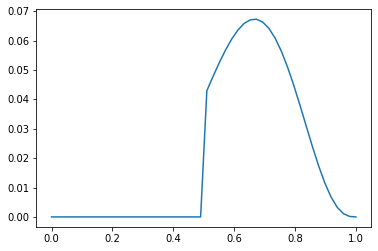

In [ ]:
N_grid = 50
grid = np.linspace(0,1, N_grid)
prior = np.zeros((N_grid))
prior[N_grid//2:] = 1

likelyhood = stats.binom.pmf(6, n=9, p=grid)
posterior_unstd = likelyhood*prior
posterior = posterior_unstd/posterior_unstd.sum()
plt.plot(grid, posterior)

## 2.6

In [ ]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()

    p_value = normal_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]


In [ ]:
print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))

Mean, Standard deviation
p 0.67, 0.16


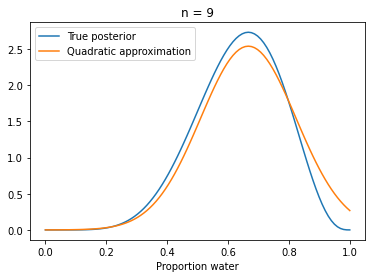

In [ ]:
# analytical calculation
w, n = 6, 9
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, w + 1, n - w + 1), label="True posterior")

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {n}")
plt.xlabel("Proportion water");

In [ ]:
n_samples = 1000
W = 6 
L = 3

def MC(n_samples, W, L):
  p = np.zeros(n_samples)
  p[0] = 0.5
  for i in range(1, n_samples):
    p_new = stats.norm(p[i-1], 0.1).rvs(1)
    if p_new < 0:
      p_new = -p_new
    if p_new > 1:
      p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W+L, p=p[i-1])
    q1 = stats.binom.pmf(W, n=W+L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
      p[i] = p_new
    else:
      p[i] = p[i-1]
  return p

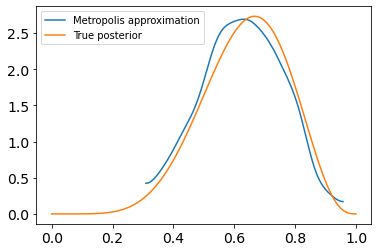

In [ ]:
p = MC(n_samples, 6, 3)
az.plot_kde(p, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();



# Questions

## 2M1
Recall the globe tossing model from the chapter. Compute and plot the grid approximate
posterior distribution for each of the following sets of observations. In each case, assume a uniform
prior for p.
1.  W, W, W
2.  W, W, W, L
3.  L, W, W, L, W, W, W

In [ ]:
n_grid = 200
n_land = 0
n_total = 3

def grid(n_land, n_total, n_grid=200):
  p_grid = np.linspace(0, 1, n_grid)
  prior = np.ones(n_grid)

  likelyhood = stats.binom.pmf(n_land, n_total, p_grid)
  posterior_unstd = likelyhood*prior
  posterior = posterior_unstd/posterior_unstd.sum()

  return p_grid, posterior

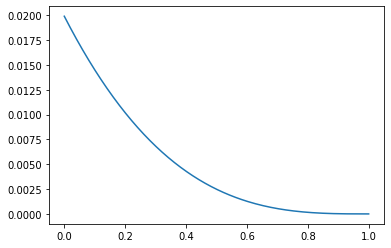

In [ ]:
plt.plot(*grid(0,3))
plt.show()

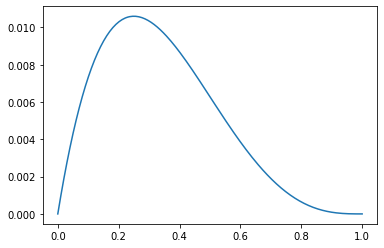

In [ ]:
plt.plot(*grid(1,4))
plt.show()

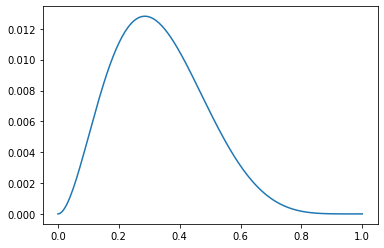

In [ ]:
plt.plot(*grid(2,7))
plt.show()

## 2M2
Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when
p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of
observations in the problem just above.

In [ ]:
def grid(n_land, n_total, p_grid, prior):

  likelyhood = stats.binom.pmf(n_land, n_total, p_grid)
  posterior_unstd = likelyhood*prior
  posterior = posterior_unstd/posterior_unstd.sum()

  return p_grid, posterior

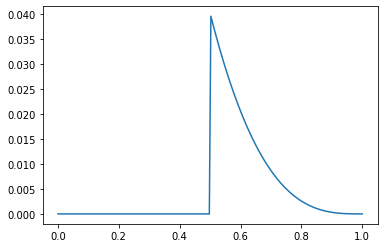

In [ ]:
n_grid = 200
p_grid = np.linspace(0, 1, n_grid)
prior = np.ones(n_grid)

prior[p_grid<0.5] = 0

plt.plot(*grid(0,3, p_grid, prior))
plt.show()

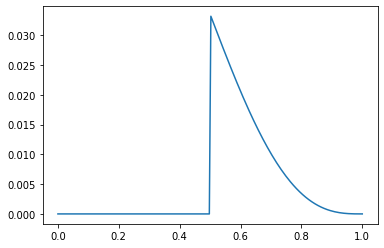

In [ ]:
plt.plot(*grid(1,4, p_grid, prior))
plt.show()

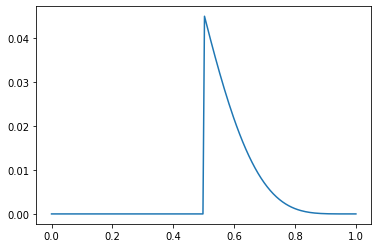

In [ ]:
plt.plot(*grid(2,7, p_grid, prior))
plt.show()

## 2M3

Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered
in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know
which—was tossed in the air and produced a “land” observation. Assume that each globe was equally
likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on
seeing “land” (Pr(Earth|land)), is 0.23.

In [ ]:
p_land_given_earth = 0.3
p_land_given_mars = 1
p_earth = 0.5
p_land = p_earth*p_land_given_earth + (1-p_earth)*p_land_given_mars

p_earth_given_land = p_land_given_earth * p_earth / p_land
p_earth_given_land

0.23076923076923075

# 2M4
Suppose you have a deck with only three cards. Each card has two sides, and each side is either
black or white. One card has two black sides. The second card has one black and one white side. The
third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone
reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up,
but you don’t know the color of the side facing down. Show that the probability that the other side is
also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This
means counting up the ways that each card could produce the observed data (a black side facing up
on the table)

This lends itself to writing more than code

Options:
* B B
* B W
* W W
* B B
* W B
* W W

First pick is 1/2 half - but given B is first we are left with choices
* B B
* B B 
* B W

So B B prob is 2/3 

## 2M5
Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is
drawn from the bag and a black side appears face up. Again calculate the probability that the other
side is black.

This equates to adding 2 more B B options to the latter half of 2M4, so we have p=4/5 

## 2M6
Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white
sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume
there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that
for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to
pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that
the probability the other side is black is now 0.5. Use the counting method, as before.

3 cards with different chances of being picked
* c_BB = 1
* c_BW = 2
* c_WW = 3

Similar case as before just with added weights:

*  B B, w=1
*   B B, w=1
*   B W, w=2

SO p = 2/4 = 1/2



## 2M7

Assume again the original card problem, with a single card showing a black side face up. Before
looking at the other side, we draw another card from the bag and lay it face up on the table. The face
that is shown on the new card is white. Show that the probability that the first card, the one showing
a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat
this like the sequence of globe tosses, counting all the ways to see each observation, for each possible
first card.

Summary:
* 3 cards
* First face black
* 2nd card one face is white

Options:

* BB WW
* BB WW
* BB WB
* BB WW
* BB WW
* BB WB
* BW WW
* BW WW

pBB = 6/8 = 3/4


# 2H1
Suppose there are two species of panda bear. Both are equally common in the wild and live
in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay
capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins
10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise
birthing singleton infants. Assume these numbers are known with certainty, from many years of field
research.

Now suppose you are managing a captive panda breeding program. You have a new female panda
of unknown species, and she has just given birth to twins. What is the probability that her next birth
will also be twins?

In [ ]:
psA = 0.5
psB = 1 - psA
psAtwins = 0.1
psBtwins = 0.2

ptwins = psA*psAtwins + psB*psBtwins

psA_given_twins = psAtwins * psA / ptwins
psB_given_twins = psBtwins * psB / ptwins

p_twins_given_twins = psA_given_twins*psAtwins + psB_given_twins*psBtwins
p_twins_given_twins

0.16666666666666666

In [ ]:
## Doing this more in line with the book
likelyhood_twins = np.array([0.1, 0.2])
prior = np.ones(2)

posterior_unstd = likelyhood_twins*prior
posterior = posterior_unstd/posterior_unstd.sum()

(posterior*likelyhood_twins).sum()

0.16666666666666666

## 2H2
Recall all the facts from the problem above. Now compute the probability that the panda we
have is from species A, assuming we have observed only the first birth and that it was twins.

In [ ]:
posterior[0]

0.3333333333333333

## 2H3
Continuing on from the previous problem, suppose the same panda mother has a second birth
and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is
species A.

In [ ]:

likelyhood_twin_singleton = likelyhood_twins*(1-likelyhood_twins)

posterior_unstd = likelyhood_twin_singleton*prior
posterior = posterior_unstd/posterior_unstd.sum()

posterior[0]

0.36

## 2H4
A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of
the data, even if the data are of different types.
So suppose now that a veterinarian comes along who has a new genetic test that she claims can
identify the species of our mother panda. But the test, like all tests, is imperfect. This is the informa-
tion you have about the test:
* The probability it correctly identifies a species A panda is 0.8.
* The probability it correctly identifies a species B panda is 0.65.

The vet administers the test to your panda and tells you that the test is positive for species A. First
ignore your previous information from the births and compute the posterior probability that your
panda is species A. Then redo your calculation, now using the birth data as well.
given test is A - what is panda

In [ ]:
likelyhood_test = np.array([0.8, 1-0.65])
prior = np.ones(2)

posterior_unstd = likelyhood_test*prior
posterior = posterior_unstd/posterior_unstd.sum()

posterior[0]

0.6956521739130436

In [ ]:
posterior_unstd = likelyhood_test*prior*likelyhood_twin_singleton
posterior = posterior_unstd/posterior_unstd.sum()

posterior[0]

0.5625